<a href="https://colab.research.google.com/github/chloemai/Capstone2/blob/main/Capstone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
#from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
#from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.regularizers import l2

In [2]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Check contents

!ls "/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/"

Chest_xray_Corona_Metadata.csv	test  train


In [4]:
# Import images

import pathlib
train = pathlib.Path('/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/train') 
test = pathlib.Path('/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/test') 
count_train = len(list(train.glob('*.jp*')))
count_test = len(list(test.glob('*.jp*')))
print(count_train, count_test)

5301 624


In [5]:
# Import labels

labels = pd.read_csv('/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_Metadata.csv')
labels.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [6]:
# Remove index label column
labels = labels.iloc[:,1:]
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   X_ray_image_name        5910 non-null   object
 1   Label                   5910 non-null   object
 2   Dataset_type            5910 non-null   object
 3   Label_2_Virus_category  69 non-null     object
 4   Label_1_Virus_category  4334 non-null   object
dtypes: object(5)
memory usage: 231.0+ KB


In [7]:
# Explore labels

print(labels.groupby('Label').size(),
labels.groupby('Label_2_Virus_category').size(),
labels.groupby('Label_1_Virus_category').size())

Label
Normal      1576
Pnemonia    4334
dtype: int64 Label_2_Virus_category
ARDS              2
COVID-19         58
SARS              4
Streptococcus     5
dtype: int64 Label_1_Virus_category
Stress-Smoking       2
Virus             1555
bacteria          2777
dtype: int64


In [8]:
# Eliminate low count images
labels = labels[labels.Label_1_Virus_category != 'Stress-Smoking']
labels = labels[~(labels.Label_2_Virus_category.isin(['ARDS','SARS','Streptococcus']))]
print(labels.groupby('Label').size(),
labels.groupby('Label_2_Virus_category').size(),
labels.groupby('Label_1_Virus_category').size())

Label
Normal      1576
Pnemonia    4323
dtype: int64 Label_2_Virus_category
COVID-19    58
dtype: int64 Label_1_Virus_category
Virus       1551
bacteria    2772
dtype: int64


In [9]:
# Replace NULL labels
labels[labels.Label == 'Normal'] = labels[labels.Label == 'Normal'].fillna('Normal')
labels.head()
print(labels.groupby('Label').size(),
labels.groupby('Label_2_Virus_category').size(),
labels.groupby('Label_1_Virus_category').size())

Label
Normal      1576
Pnemonia    4323
dtype: int64 Label_2_Virus_category
COVID-19      58
Normal      1576
dtype: int64 Label_1_Virus_category
Normal      1576
Virus       1551
bacteria    2772
dtype: int64


In [10]:
labels = labels.fillna('Other')
print(labels.groupby('Label').size(),
labels.groupby('Label_2_Virus_category').size(),
labels.groupby('Label_1_Virus_category').size())
labels.reset_index(inplace = True)
labels.info()

Label
Normal      1576
Pnemonia    4323
dtype: int64 Label_2_Virus_category
COVID-19      58
Normal      1576
Other       4265
dtype: int64 Label_1_Virus_category
Normal      1576
Virus       1551
bacteria    2772
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5899 entries, 0 to 5898
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   5899 non-null   int64 
 1   X_ray_image_name        5899 non-null   object
 2   Label                   5899 non-null   object
 3   Dataset_type            5899 non-null   object
 4   Label_2_Virus_category  5899 non-null   object
 5   Label_1_Virus_category  5899 non-null   object
dtypes: int64(1), object(5)
memory usage: 276.6+ KB


In [11]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.8, 1.2),
                              zoom_range=[0.75, 1],
                              horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [12]:
from sklearn.model_selection import train_test_split
train_df = labels[labels.Dataset_type == 'TRAIN']
train_df_norm = train_df[train_df.Label == 'Normal']
train_df_pne = train_df[train_df.Label == 'Pnemonia']
#train_df = pd.concat([train_df_norm[:500],train_df_pne[:500]])
train_df = pd.concat([train_df_norm,train_df_pne])
X_train, X_valid, y_train, y_valid = train_test_split(train_df['X_ray_image_name'], train_df['Label'], test_size = 0.1, random_state = 42)
train_df = pd.concat([X_train, y_train], axis = 1)
valid_df = pd.concat([X_valid, y_valid], axis = 1)

train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             batch_size = 32)

valid_batches = train_datagen.flow_from_dataframe(valid_df,
                                              directory = train,
                                              x_col='X_ray_image_name',
                                              y_col='Label',
                                              batch_size = 32)
test_df = labels[labels.Dataset_type == 'TEST']
test_batches = test_datagen.flow_from_dataframe(test_df,
                                             directory=test,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             batch_size = 32)
#test_df.sample(100)
# batch size comes in powers of 2. try medium of 32 of 64. larger batch size might be more accurate but will take longer
# window size - maybe buckets of 3 like 3x3.
# change class_mode to include more labels

# Should I indicate a batch size?

Found 4747 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [13]:
valid_df.head()

,X_ray_image_name,Label
8,IM-0187-0001.jpeg,Normal
655,NORMAL2-IM-0478-0001.jpeg,Normal
3349,person278_bacteria_1314.jpeg,Pnemonia
3264,person298_bacteria_1412.jpeg,Pnemonia
465,IM-0628-0001.jpeg,Normal


A - input (k x m) 
B - 1st hidden layer (m x n)
A is a set of images - k = # of samples and m is the dimension of each input sample
B - n is hidden layer size = output size

Is my m from the input layer, the whole 4d tuple?

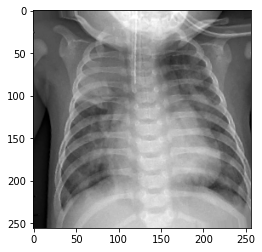

In [14]:
batch = next(train_batches)
plt.imshow(batch[0][0].astype('uint8'))
#print(train_df[train_df.X_ray_image_name == batch[0][0]].Label)

In [15]:
train_batches[0][0][0].shape

(256, 256, 3)

In [16]:
batch[0][0].shape

(256, 256, 3)

In [17]:
train_batches_series = pd.Series(train_batches.classes)
test_batches_series = pd.Series(test_batches.classes)
print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in test_batches: \n{ test_batches_series.value_counts() }')

Value count in train_batches: 
1    3551
0    1196
dtype: int64
Value count in test_batches: 
1    390
0    234
dtype: int64


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential()
Input_shape=(32, 256, 256, 3)
model.add(Conv2D(16, kernel_size=(2,2), padding="same", activation='relu', input_shape=Input_shape[1:]))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
hist = model.fit(train_batches, epochs = 10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 2)                 524290    
                                                                 
Total params: 524,498
Trainable params: 524,498
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
149/149 [==============================] - 260s 818ms/step - loss: 936.4476 - accuracy: 0.7756
Epoch 2/10

In [19]:
# Test model_1
from sklearn.metrics import confusion_matrix

pred = model.predict(test_batches)
predicted_class_indices=np.argmax(pred,axis=1)
test_labels = (test_batches.class_indices)
labels = dict((v,k) for k,v in test_labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)
cf_matrix = confusion_matrix(predicted_class_indices,test_batches.classes)
print(cf_matrix)

[1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1
 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0
 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 0 1 1 1 1 1 0 

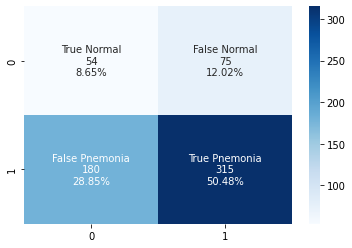

In [20]:
import seaborn as sns

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

12/5: Training all of the data took about 25 min. Model accuracy was 85%. Took a subset to make modeling faster. With a random set of 1000 for train and 10 for test, the model was 65% accurate. The random train samples were about 75% pnemonia. So I manipulated train and made it 50/50 norm/pnemonia, and the model ended up being 55% accurate -- why less? Why does model_evaluate have different scores than fit? For the original random small data, the test data ended up guessing everything was Pnemonia. The new model has a confusion matrix of [15, 16][22, 47]. So accuray = 62%. That's better.

These smaller models take about 7 min to run. 

In [21]:
# Create CNN model_1 - predict Pneumonia vs normal
model_1 = Sequential()
Input_shape=(None, 256, 256, 3)
model_1.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu', input_shape=Input_shape[1:]))
model_1.add(MaxPooling2D())
model_1.add(Conv2D(16, kernel_size=(2,2), padding="same", activation='relu'))
model_1.add(MaxPooling2D())
model_1.add(Flatten())
model_1.add(Dense(2, activation='softmax'))
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_1.summary()
hist_1 = model_1.fit(train_batches, epochs = 10)

# use default for MaxPool2D - higher pool_size means further reduction of parameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      416       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      2064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                

[0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0
 1 0 1 1 1 0 0 0 0 1 1 0 

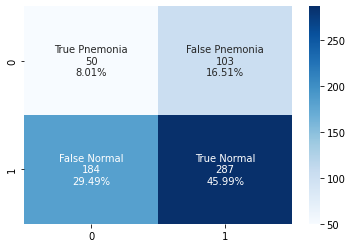

In [22]:
pred_1 = model_1.predict(test_batches)
predicted_class_indices_1=np.argmax(pred_1,axis=1)
labels_1 = dict((v,k) for k,v in test_labels.items())
predictions_1 = [labels_1[k] for k in predicted_class_indices_1]
print(predicted_class_indices_1)
print(labels_1)
print(predictions_1)
cf = confusion_matrix(predicted_class_indices_1,test_batches.classes)
print(cf)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)      

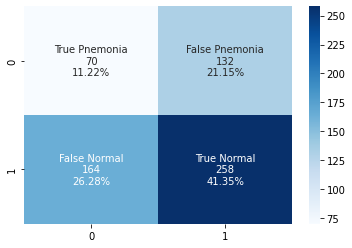

In [23]:
model_2 = Sequential()
Input_shape=(None, 256, 256, 3)
model_2.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu', input_shape=Input_shape[1:]))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(64, kernel_size=(2,2), padding="same", activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(16, kernel_size=(2,2), padding="same", activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(2, activation='softmax'))
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()
hist_2 = model_2.fit(train_batches, epochs = 10)

pred_2 = model_2.predict(test_batches)
predicted_class_indices_2=np.argmax(pred_2,axis=1)
labels_2 = dict((v,k) for k,v in test_labels.items())
predictions_2 = [labels_2[k] for k in predicted_class_indices_2]
print(predicted_class_indices_2)
print(labels_2)
print(predictions_2)
cf2 = confusion_matrix(predicted_class_indices_2,test_batches.classes)
print(cf2)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf2.flatten()/np.sum(cf2)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf2, annot=labels, fmt='', cmap='Blues')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 128)     1664      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)      

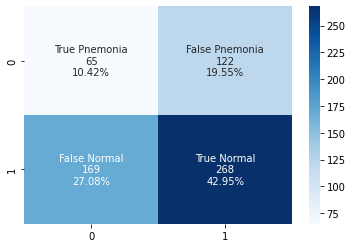

In [24]:
model_3 = Sequential()
Input_shape=(None, 256, 256, 3)
model_3.add(Conv2D(128, kernel_size=(2,2), padding="same", activation='relu', input_shape=Input_shape[1:]))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(64, kernel_size=(2,2), padding="same", activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(16, kernel_size=(2,2), padding="same", activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Flatten())
model_3.add(Dense(2, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_3.summary()
hist_3 = model_3.fit(train_batches, epochs = 10)

pred_3 = model_3.predict(test_batches)
predicted_class_indices_3=np.argmax(pred_3,axis=1)
labels_3 = dict((v,k) for k,v in test_labels.items())
predictions_3 = [labels_3[k] for k in predicted_class_indices_3]
print(predicted_class_indices_3)
print(labels_3)
print(predictions_3)
cf3 = confusion_matrix(predicted_class_indices_3,test_batches.classes)
print(cf3)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf3.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf3.flatten()/np.sum(cf3)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf3, annot=labels, fmt='', cmap='Blues')

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model_4 = Sequential()
Input_shape=(None, 256, 256, 3)
model_4.add(Conv2D(64, kernel_size=(2,2), padding="same", activation='relu', input_shape=Input_shape[1:]))
model_4.add(MaxPooling2D())
model_4.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu'))
model_4.add(MaxPooling2D())
model_4.add(Conv2D(16, kernel_size=(2,2), padding="same", activation='relu'))
model_4.add(MaxPooling2D())
model_4.add(Flatten())
model_4.add(Dense(2, activation='softmax'))
model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_4.summary()
hist_4 = model_4.fit(train_batches, epochs = 20)

from sklearn.metrics import confusion_matrix
pred_4 = model_4.predict(test_batches)
predicted_class_indices_4=np.argmax(pred_4,axis=1)
test_labels = (test_batches.class_indices)
labels_4 = dict((v,k) for k,v in test_labels.items())
predictions_4 = [labels_4[k] for k in predicted_class_indices_4]
print(predicted_class_indices_4)
print(labels_4)
print(predictions_4)
cf4 = confusion_matrix(predicted_class_indices_4,test_batches.classes)
print(cf4)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf4.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf4.flatten()/np.sum(cf4)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf4, annot=labels, fmt='', cmap='Blues')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

NameError: ignored

[1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1
 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1
 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1
 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0
 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1
 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1
 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0
 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1
 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0
 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0
 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1
 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1
 1 1 0 1 0 1 1 1 1 1 0 1 

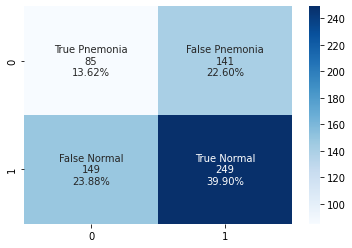

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_4 = model_4.predict(test_batches)
predicted_class_indices_4=np.argmax(pred_4,axis=1)
test_labels = (test_batches.class_indices)
labels_4 = dict((v,k) for k,v in test_labels.items())
predictions_4 = [labels_4[k] for k in predicted_class_indices_4]
print(predicted_class_indices_4)
print(labels_4)
print(predictions_4)
cf4 = confusion_matrix(predicted_class_indices_4,test_batches.classes)
print(cf4)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf4.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf4.flatten()/np.sum(cf4)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf4, annot=labels, fmt='', cmap='Blues')

Epoch 1/20
149/149 [==============================] - 148s 993ms/step - loss: 0.2328 - accuracy: 0.9107
Epoch 2/20
149/149 [==============================] - 149s 997ms/step - loss: 0.2342 - accuracy: 0.9071
Epoch 3/20
149/149 [==============================] - 147s 989ms/step - loss: 0.2171 - accuracy: 0.9153
Epoch 4/20
149/149 [==============================] - 149s 1s/step - loss: 0.2183 - accuracy: 0.9189
Epoch 5/20
149/149 [==============================] - 150s 1s/step - loss: 0.2235 - accuracy: 0.9136
Epoch 6/20
149/149 [==============================] - 149s 1s/step - loss: 0.2246 - accuracy: 0.9075
Epoch 7/20
149/149 [==============================] - 149s 996ms/step - loss: 0.1981 - accuracy: 0.9240
Epoch 8/20
149/149 [==============================] - 149s 1000ms/step - loss: 0.2254 - accuracy: 0.9138
Epoch 9/20
149/149 [==============================] - 148s 993ms/step - loss: 0.2044 - accuracy: 0.9191
Epoch 10/20
149/149 [==============================] - 149s 1s/step - lo

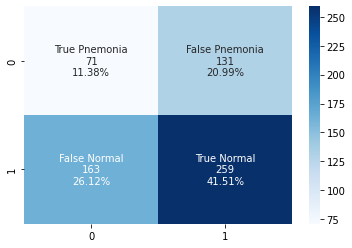

In [18]:
hist_4_1 = model_4.fit(train_batches, epochs = 20)
pred_4 = model_4.predict(test_batches)
predicted_class_indices_4=np.argmax(pred_4,axis=1)
labels_4 = dict((v,k) for k,v in test_labels.items())
predictions_4 = [labels_4[k] for k in predicted_class_indices_4]
print(predicted_class_indices_4)
print(labels_4)
print(predictions_4)
cf4 = confusion_matrix(predicted_class_indices_4,test_batches.classes)
print(cf4)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf4.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf4.flatten()/np.sum(cf4)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf4, annot=labels, fmt='', cmap='Blues')

[0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1
 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1
 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0
 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1
 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0
 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1
 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 1 1 1 

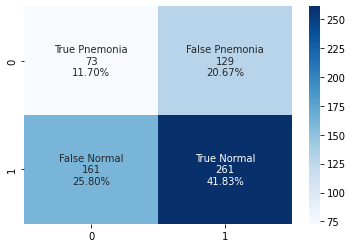

In [19]:
pred_4 = model_4.predict(test_batches)
predicted_class_indices_4=np.argmax(pred_4,axis=1)
test_labels = (test_batches.class_indices)
labels_4 = dict((v,k) for k,v in test_labels.items())
predictions_4 = [labels_4[k] for k in predicted_class_indices_4]
print(predicted_class_indices_4)
print(labels_4)
print(predictions_4)
cf4 = confusion_matrix(predicted_class_indices_4,test_batches.classes)
print(cf4)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf4.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf4.flatten()/np.sum(cf4)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf4, annot=labels, fmt='', cmap='Blues')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 256, 256, 32)      416       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 32)      

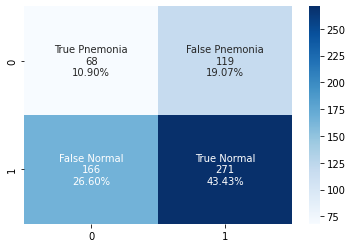

In [27]:
model_5 = Sequential()
Input_shape=(None, 256, 256, 3)
model_5.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu', input_shape=Input_shape[1:]))
model_5.add(MaxPooling2D())
model_5.add(Conv2D(64, kernel_size=(2,2), padding="same", activation='relu'))
model_5.add(MaxPooling2D())
model_5.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu'))
model_5.add(MaxPooling2D())
model_5.add(Conv2D(64, kernel_size=(2,2), padding="same", activation='relu'))
model_5.add(MaxPooling2D())
model_5.add(Conv2D(32, kernel_size=(2,2), padding="same", activation='relu'))
model_5.add(MaxPooling2D())
model_5.add(Conv2D(16, kernel_size=(2,2), padding="same", activation='relu'))
model_5.add(MaxPooling2D())
model_5.add(Flatten())
model_5.add(Dense(2, activation='softmax'))
model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_5.summary()
hist_5 = model_5.fit(train_batches, epochs = 10)

pred_5 = model_5.predict(test_batches)
predicted_class_indices_5=np.argmax(pred_5,axis=1)
labels_5 = dict((v,k) for k,v in test_labels.items())
predictions_5 = [labels_5[k] for k in predicted_class_indices_5]
print(predicted_class_indices_5)
print(labels_5)
print(predictions_5)
cf5 = confusion_matrix(predicted_class_indices_5,test_batches.classes)
print(cf5)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf5.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf5.flatten()/np.sum(cf5)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf5, annot=labels, fmt='', cmap='Blues')

In [28]:
# Transfer Learning
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


base_model = tf.keras.applications.MobileNetV2(input_shape=Input_shape[1:],
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_batches)) 

feature_batch = base_model(image_batch)
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
loss0, accuracy0 = model.evaluate(valid_batches)
initial_epochs = 10
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=valid_batches)


9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                

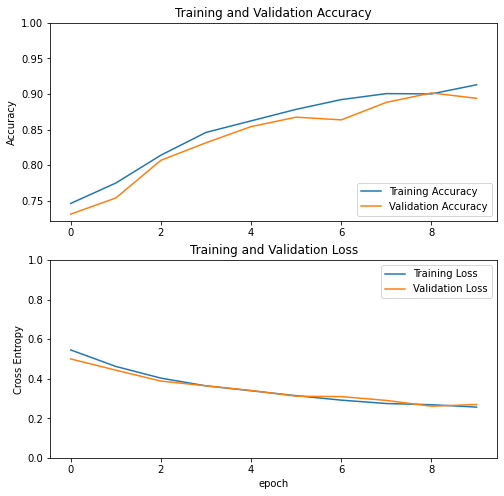

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 

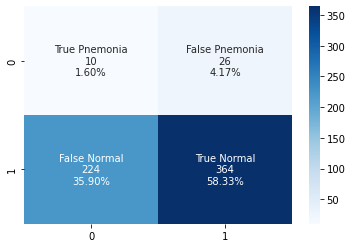

In [30]:
pred_tl = model.predict(test_batches)
predicted_class_indices_tl=np.argmax(pred_tl,axis=1)
labels_tl = dict((v,k) for k,v in test_labels.items())
predictions_tl = [labels_tl[k] for k in predicted_class_indices_tl]
print(predicted_class_indices_tl)
print(labels_tl)
print(predictions_tl)
cftl = confusion_matrix(predicted_class_indices_tl,test_batches.classes)
print(cftl)

group_names = ['True Normal','False Normal','False Pneumonia','True Pneumonia']
group_counts = ['{0:0.0f}'.format(value) for value in
                cftl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cftl.flatten()/np.sum(cftl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cftl, annot=labels, fmt='', cmap='Blues')